### Prediction of HOMO and LUMO Energies Using Random Forest Regression on QM9 Dataset (51 Features)

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import os

# Load dataset
data_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9.csv'
data = pd.read_csv(data_path)

# Prepare features and targets
X = data.drop(columns=['homo', 'lumo', 'canonical_SMILES'], errors='ignore')
y_homo = data['homo']
y_lumo = data['lumo']

# Split data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y_homo, test_size=0.2, random_state=42)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X, y_lumo, test_size=0.2, random_state=42)

# Define simple regression models
rf_homo = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

rf_lumo = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

# Train models
print("Training RandomForestRegressor for HOMO...")
rf_homo.fit(X_train_h, y_train_h)
print("Training RandomForestRegressor for LUMO...")
rf_lumo.fit(X_train_l, y_train_l)

# Evaluate models
def evaluate(model, X_test, y_test, label):
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    print(f"{label} | R²: {r2:.4f} | RMSE: {rmse:.6f} | MAE: {mae:.6f}")
    return pred

print("\n--- Model Evaluation ---")
pred_homo_test = evaluate(rf_homo, X_test_h, y_test_h, "HOMO")
pred_lumo_test = evaluate(rf_lumo, X_test_l, y_test_l, "LUMO")

# Save models
os.makedirs('E:/HLP_STACK/new_models', exist_ok=True)
joblib.dump(rf_homo, 'E:/HLP_STACK/new_models/RFRegressor_homo_QM9.pkl.gz')
joblib.dump(rf_lumo, 'E:/HLP_STACK/new_models/RFRegressor_lumo_QM9.pkl.gz')
print("\nModels saved successfully!")

# Predict on full dataset
pred_homo_full = rf_homo.predict(X)
pred_lumo_full = rf_lumo.predict(X)

results = pd.DataFrame({
    'canonical_SMILES': data['canonical_SMILES'],
    'True_HOMO (Hartree)': y_homo,
    'Predicted_HOMO (Hartree)': pred_homo_full,
    'True_LUMO (Hartree)': y_lumo,
    'Predicted_LUMO (Hartree)': pred_lumo_full
})

# Save results ---
os.makedirs('E:/HLP_STACK/results_reviewer2', exist_ok=True)
results.to_csv('E:/HLP_STACK/results_reviewer2/predicted_HOMO_LUMO_RF_QM9.csv', index=False)
print("Predictions saved to: E:/HLP_STACK/results/predicted_HOMO_LUMO_RF_QM9.csv")

print("\nSample Predictions:")
print(results.head())

Training RandomForestRegressor for HOMO...
Training RandomForestRegressor for LUMO...

--- Model Evaluation ---
HOMO | R²: 1.0000 | RMSE: 0.000132 | MAE: 0.000006
LUMO | R²: 1.0000 | RMSE: 0.000076 | MAE: 0.000003

Models saved successfully!
Predictions saved to: E:/HLP_STACK/results/predicted_HOMO_LUMO_RF_QM9.csv

Sample Predictions:
  canonical_SMILES  True_HOMO (Hartree)  Predicted_HOMO (Hartree)  \
0                C            -5.540480                 -5.540480   
1                N            -0.345075                 -0.345075   
2                O            -1.768147                 -1.768147   
3              C#C            -1.438217                 -1.438217   
4              C#N            -4.455289                 -4.455289   

   True_LUMO (Hartree)  Predicted_LUMO (Hartree)  
0             1.967471                  1.967471  
1             1.283135                  1.283135  
2             0.998996                  0.998996  
3             0.636819                  0.63

### Feature Selection via Correlation Thresholding (|r| > 0.8) for QM9 Descriptors

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv('E:/QM9_sci/smiles_2D_3D_MD_227_QM9.csv')

# Exclude non-feature columns
excluded_cols = ['homo', 'lumo', 'canonical_SMILES']
features = data.drop(columns=excluded_cols, errors='ignore')

# Compute correlation matrix again (for safety)
corr_matrix = features.corr(numeric_only=True).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.8
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Number of features to remove (|r| > {threshold}): {len(to_drop)}")
print("Features removed:")
for feat in to_drop:
    print(f"  - {feat}")

# Create reduced dataset
reduced_features = features.drop(columns=to_drop, errors='ignore')

# Add target and SMILES columns back (if you want a full dataset)
cleaned_data = pd.concat([reduced_features, data[['homo', 'lumo', 'canonical_SMILES']]], axis=1)

# Save the new dataset
save_path_cleaned = "E:/QM9_sci/smiles_2D_3D_MD_227_QM9_reduced_corr08.csv"
cleaned_data.to_csv(save_path_cleaned, index=False)

print(f"\nCleaned dataset saved to:\n{save_path_cleaned}")
print(f"Original features: {features.shape[1]}")
print(f"Remaining features: {reduced_features.shape[1]}")
print(f"Removed features: {len(to_drop)}")

Number of features to remove (|r| > 0.8): 9
Features removed:
  - Chi1n
  - Chi1v
  - Steric Hindrance
  - Chi3v
  - u0
  - u298
  - cv
  - h298
  - BCUT2D_LOGPLOW

Cleaned dataset saved to:
E:/QM9_sci/smiles_2D_3D_MD_227_QM9_reduced_corr08.csv
Original features: 51
Remaining features: 42
Removed features: 9


### Random Forest Modeling of HOMO/LUMO Energies After Feature Reduction (|r| > 0.8)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import os

# Load dataset
data_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9_reduced_corr08.csv'
data2 = pd.read_csv(data_path)

# Prepare features and targets
X = data2.drop(columns=['homo', 'lumo', 'canonical_SMILES'], errors='ignore')
y_homo = data2['homo']
y_lumo = data2['lumo']

# Split data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y_homo, test_size=0.2, random_state=42)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X, y_lumo, test_size=0.2, random_state=42)

# Define simple regression models
rf_homo = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

rf_lumo = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

# Train models
print("Training RandomForestRegressor for HOMO...")
rf_homo.fit(X_train_h, y_train_h)
print("Training RandomForestRegressor for LUMO...")
rf_lumo.fit(X_train_l, y_train_l)

# Evaluate models
def evaluate(model, X_test, y_test, label):
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    print(f"{label} | R²: {r2:.4f} | RMSE: {rmse:.6f} | MAE: {mae:.6f}")
    return pred

print("\n--- Model Evaluation ---")
pred_homo_test = evaluate(rf_homo, X_test_h, y_test_h, "HOMO")
pred_lumo_test = evaluate(rf_lumo, X_test_l, y_test_l, "LUMO")

# Save models
os.makedirs('E:/HLP_STACK/new_models', exist_ok=True)
joblib.dump(rf_homo, 'E:/HLP_STACK/new_models/RFRegressor_homo_QM9_corr08.pkl.gz')
joblib.dump(rf_lumo, 'E:/HLP_STACK/new_models/RFRegressor_lumo_QM9_corr08.pkl.gz')
print("\nModels saved successfully!")

# Predict on full dataset
pred_homo_full = rf_homo.predict(X)
pred_lumo_full = rf_lumo.predict(X)

results = pd.DataFrame({
    'canonical_SMILES': data2['canonical_SMILES'],
    'True_HOMO (Hartree)': y_homo,
    'Predicted_HOMO (Hartree)': pred_homo_full,
    'True_LUMO (Hartree)': y_lumo,
    'Predicted_LUMO (Hartree)': pred_lumo_full
})

# Save results
os.makedirs('E:/HLP_STACK/results_reviewer2', exist_ok=True)
results.to_csv('E:/HLP_STACK/results_reviewer2/predicted_HOMO_LUMO_RF_QM9_corr08.csv', index=False)
print("Predictions saved to: E:/HLP_STACK/results/predicted_HOMO_LUMO_RF_QM9_corr08.csv")

print("\nSample Predictions:")
print(results.head())

Training RandomForestRegressor for HOMO...
Training RandomForestRegressor for LUMO...

--- Model Evaluation ---
HOMO | R²: 1.0000 | RMSE: 0.000245 | MAE: 0.000019
LUMO | R²: 1.0000 | RMSE: 0.000199 | MAE: 0.000014

Models saved successfully!
Predictions saved to: E:/HLP_STACK/results/predicted_HOMO_LUMO_RF_QM9_corr08.csv

Sample Predictions:
  canonical_SMILES  True_HOMO (Hartree)  Predicted_HOMO (Hartree)  \
0                C            -5.540480                 -5.540480   
1                N            -0.345075                 -0.345075   
2                O            -1.768147                 -1.768147   
3              C#C            -1.438217                 -1.438217   
4              C#N            -4.455289                 -4.455289   

   True_LUMO (Hartree)  Predicted_LUMO (Hartree)  
0             1.967471                  1.967471  
1             1.283135                  1.283135  
2             0.998996                  0.998996  
3             0.636819               

In [ ]:
# --- Model Evaluation ---
# HOMO | R²: 1.0000 | RMSE: 0.000132 | MAE: 0.000006
# LUMO | R²: 1.0000 | RMSE: 0.000076 | MAE: 0.000003

# --- Model Evaluation ---
# HOMO | R²: 1.0000 | RMSE: 0.000245 | MAE: 0.000019
# LUMO | R²: 1.0000 | RMSE: 0.000199 | MAE: 0.000014


### Visualization of Inter-Feature Correlations in QM9 Molecular Descriptors (|r| ≤ 0.8)

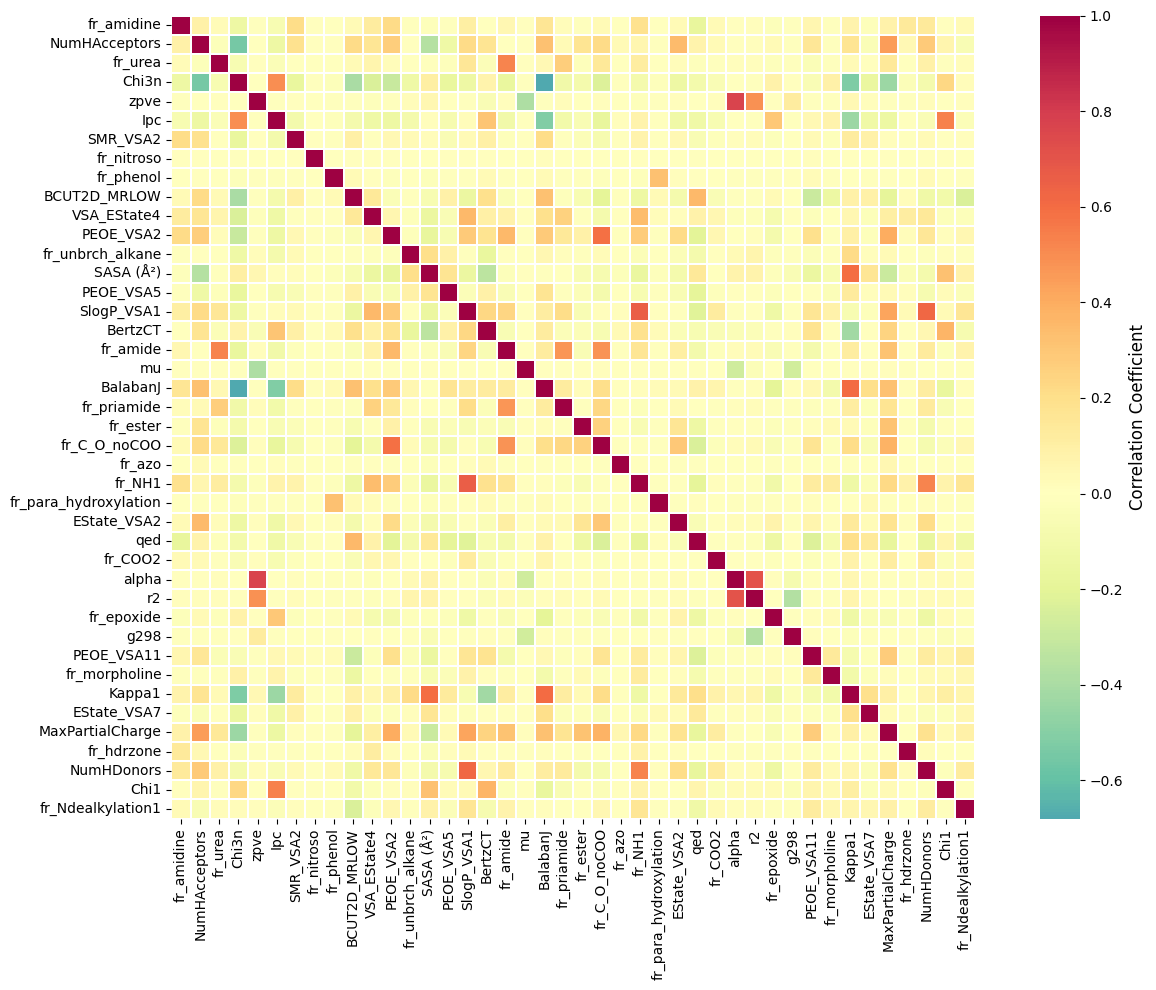

Correlation heatmap saved at:
E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_Spectral_r_corr08.png


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9_reduced_corr08.csv'
data2 = pd.read_csv(data_path)

# Exclude non-feature columns
excluded_cols = ['homo', 'lumo', 'canonical_SMILES']
features = data2.drop(columns=excluded_cols, errors='ignore')

# Compute correlation matrix
corr_matrix = features.corr(numeric_only=True)

# Display the top 10 most correlated feature pairs (absolute correlation)
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1.0]  # remove self-correlations
top_corr = corr_pairs.abs().sort_values(ascending=False).head(10)

# Create a mask for the upper triangle
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the plot
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    corr_matrix,
    # mask=mask, 
    cmap='Spectral_r',         
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation Coefficient'},
    xticklabels=True,
    yticklabels=True,
    linewidths=0.3
)

# Customize label sizes and rotation
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y', labelsize=10)

# Customize colorbar label size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation Coefficient', fontsize=12)

plt.tight_layout()

# Save plot
save_path = "E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_Spectral_r_corr08.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Correlation heatmap saved at:\n{save_path}")

### Visualization of Strong Inter-Feature Correlations in QM9 Molecular Descriptors (|r| > 0.8)

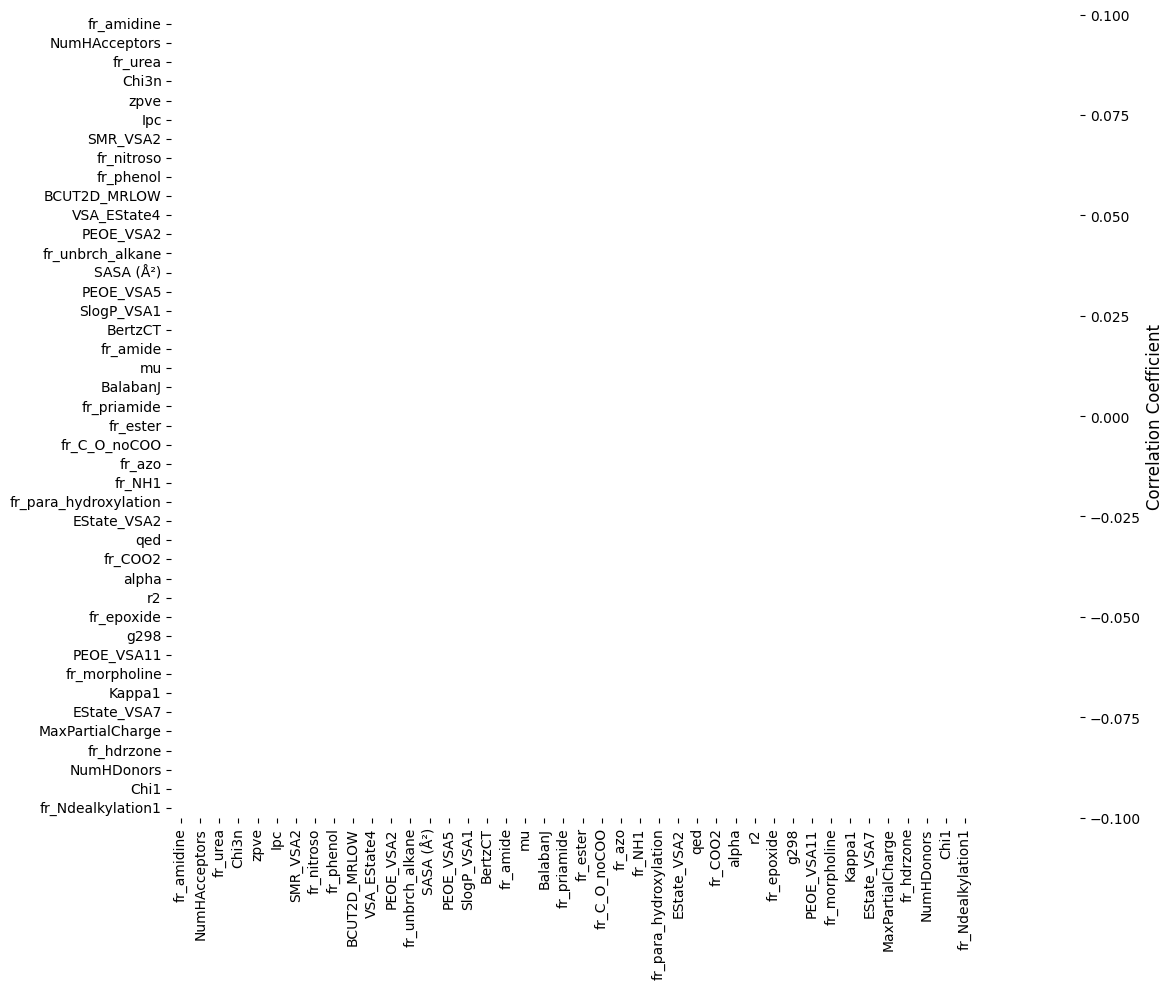

Correlation heatmap (|r| > 0.8) saved at:
E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_corr_8-2.png


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
data_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9_reduced_corr08.csv'
data2 = pd.read_csv(data_path)

# Exclude non-feature columns
excluded_cols = ['homo', 'lumo', 'canonical_SMILES']
features = data2.drop(columns=excluded_cols, errors='ignore')

# Compute correlation matrix
corr_matrix = features.corr(numeric_only=True)

# Apply threshold mask: keep only |r| > 0.8
threshold = 0.8
mask_low_corr = corr_matrix.abs() < threshold
filtered_corr = corr_matrix.mask(mask_low_corr)

# Create the plot
plt.figure(figsize=(14, 10))

# Create a copy of your correlation matrix and replace NaN with 0
corr_plot = filtered_corr.copy()
corr_plot = corr_plot.fillna(0)  # fill hidden cells with neutral value

# Create a lower-triangle mask
mask_lower = np.triu(np.ones_like(filtered_corr, dtype=bool))  # upper triangle hidden

# Combine both masks: upper triangle + NaNs
combined_mask = mask_lower | filtered_corr.isna()

ax = sns.heatmap(
    corr_plot,
    mask=combined_mask,
    cmap='Spectral_r',
    center=0,
    square=True,
    linewidths=0.3,
    cbar_kws={'label': 'Correlation Coefficient'},
    xticklabels=True,
    yticklabels=True
)

# Set background color to white
ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

# Customize tick labels
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y', labelsize=10)

# Customize colorbar label size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation Coefficient', fontsize=12)

plt.tight_layout()

# Save plot
save_path = "E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_corr_8-2.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Correlation heatmap (|r| > {threshold}) saved at:\n{save_path}")

### Feature Pruning Script for QM9 (Removing g298, u0, Chi3n, Chi1n, Chi3v, h298)

In [34]:
import pandas as pd

# Load dataset
data_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9.csv'
data = pd.read_csv(data_path)

# Columns to remove
cols_to_remove = ['g298', 'u0', 'Chi3n', 'Chi1n', 'Chi3v', 'h298']

# Drop columns (ignore missing)
cleaned_data = data.drop(columns=cols_to_remove, errors='ignore')

# Save cleaned dataset
save_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9_removed_energy_terms.csv'
cleaned_data.to_csv(save_path, index=False)

# Summary
print("Cleaned dataset saved successfully.")
print(f"Saved to: {save_path}")
print(f"Original columns: {data.shape[1]}")
print(f"Remaining columns: {cleaned_data.shape[1]}")
print(f"Removed columns: {', '.join(cols_to_remove)}")


Cleaned dataset saved successfully.
Saved to: E:/QM9_sci/smiles_2D_3D_MD_227_QM9_removed_energy_terms.csv
Original columns: 54
Remaining columns: 48
Removed columns: g298, u0, Chi3n, Chi1n, Chi3v, h298


### Inter-Feature Correlation Analysis of QM9 Molecular Descriptors Excluding Energy Terms

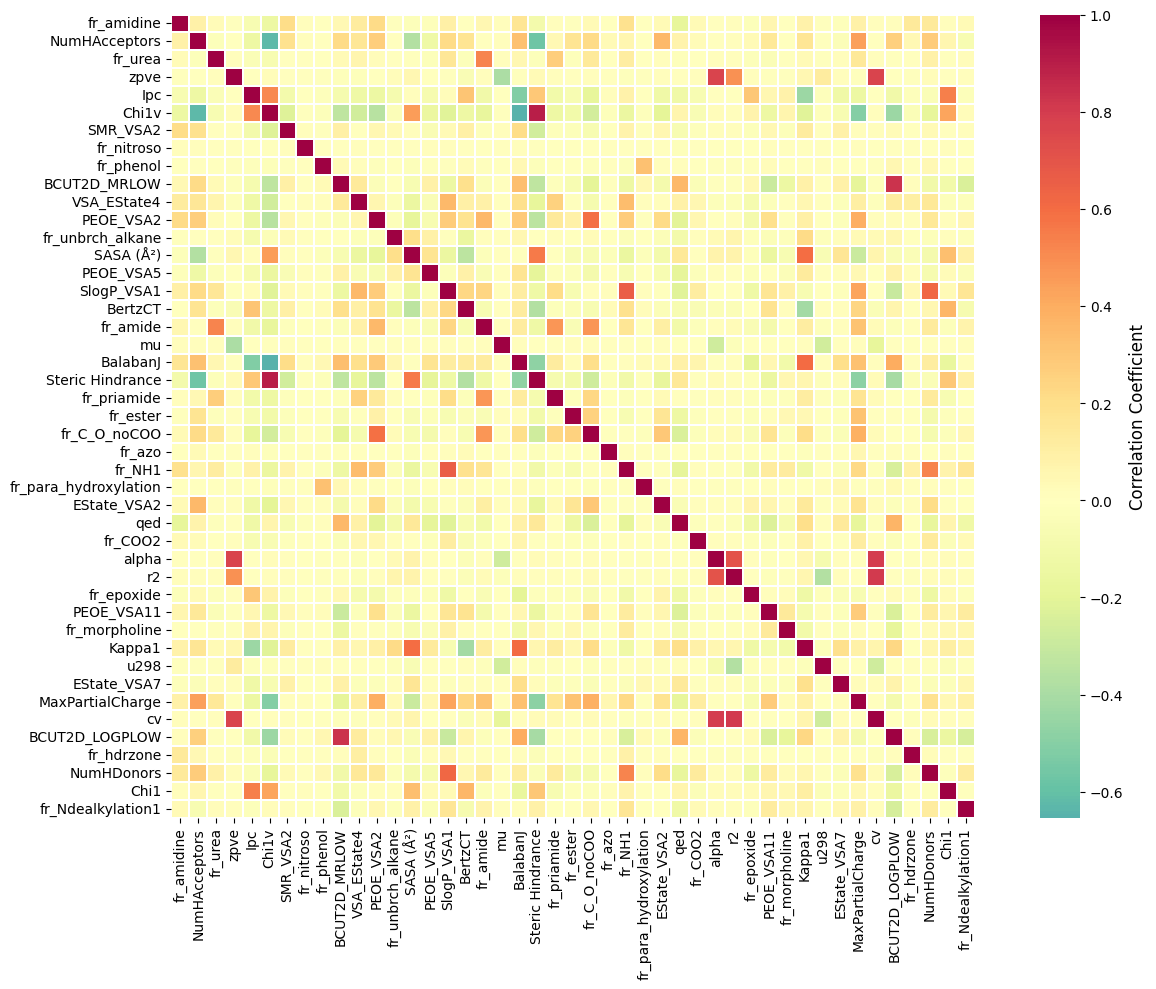

Correlation heatmap saved at:
E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_Spectral_r_removed_energy_terms.png


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
save_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9_removed_energy_terms.csv'
data3 = pd.read_csv(save_path)

# Exclude non-feature columns
excluded_cols = ['homo', 'lumo', 'canonical_SMILES']
features = data3.drop(columns=excluded_cols, errors='ignore')

# Compute correlation matrix
corr_matrix = features.corr(numeric_only=True)

# Display the top 10 most correlated feature pairs (absolute correlation)
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1.0]  # remove self-correlations
top_corr = corr_pairs.abs().sort_values(ascending=False).head(10)

# Create a mask for the upper triangle
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the plot
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    corr_matrix,
    # mask=mask, 
    cmap='Spectral_r',         
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation Coefficient'},
    xticklabels=True,
    yticklabels=True,
    linewidths=0.3
)

# Customize label sizes and rotation
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y', labelsize=10)

# Customize colorbar label size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation Coefficient', fontsize=12)

plt.tight_layout()

# Save plot
save_path = "E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_Spectral_r_removed_energy_terms.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Correlation heatmap saved at:\n{save_path}")

### Visualization of Strong Inter-Feature Correlations (|r| > 0.8) in QM9 Molecular Descriptors After Removing Energy Terms

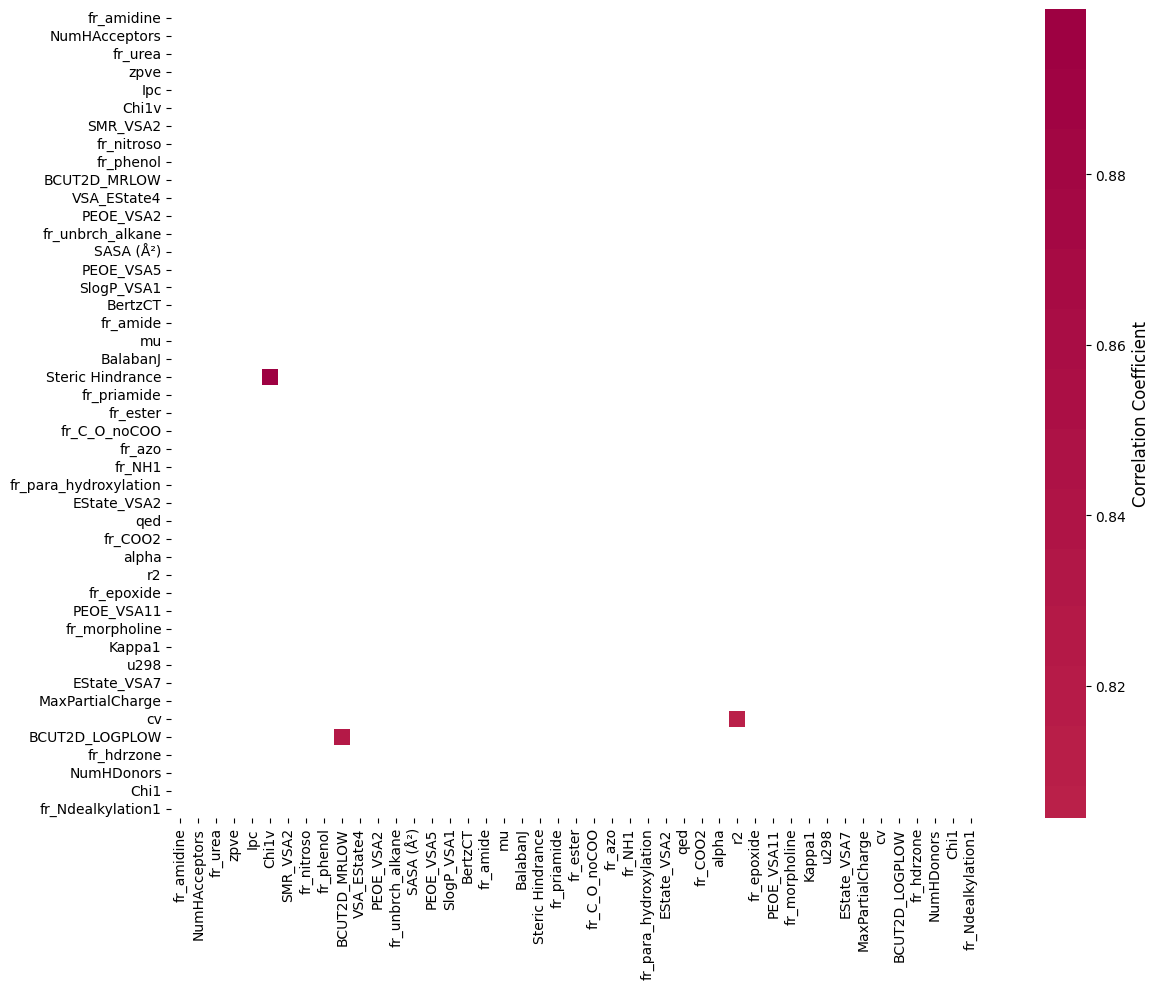

Correlation heatmap (|r| > 0.8) saved at:
E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_r_removed_energy_terms.png


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load data
save_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9_removed_energy_terms.csv'
data3 = pd.read_csv(save_path)

# Exclude non-feature columns
excluded_cols = ['homo', 'lumo', 'canonical_SMILES']
features = data3.drop(columns=excluded_cols, errors='ignore')

# Compute correlation matrix
corr_matrix = features.corr(numeric_only=True)

# Apply threshold mask: keep only |r| > 0.8
threshold = 0.8
mask_low_corr = corr_matrix.abs() < threshold
filtered_corr = corr_matrix.mask(mask_low_corr)

# Create the plot
plt.figure(figsize=(14, 10))

# Create a copy of your correlation matrix and replace NaN with 0
corr_plot = filtered_corr.copy()
corr_plot = corr_plot.fillna(0)  # fill hidden cells with neutral value

# Create a lower-triangle mask
mask_lower = np.triu(np.ones_like(filtered_corr, dtype=bool))  # upper triangle hidden

# Combine both masks: upper triangle + NaNs
combined_mask = mask_lower | filtered_corr.isna()

ax = sns.heatmap(
    corr_plot,
    mask=combined_mask,
    cmap='Spectral_r',
    center=0,
    square=True,
    linewidths=0.3,
    cbar_kws={'label': 'Correlation Coefficient'},
    xticklabels=True,
    yticklabels=True
)

# Set background color to white
ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

# Customize tick labels
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y', labelsize=10)

# Customize colorbar label size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation Coefficient', fontsize=12)

plt.tight_layout()

# Save plot
save_path = "E:/QM9_sci/Mean HOMO-LUMO Gap vs Carbon Count/feature_correlation_heatmap_r_removed_energy_terms.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Correlation heatmap (|r| > {threshold}) saved at:\n{save_path}")

In [25]:
data3.columns

Index(['fr_amidine', 'NumHAcceptors', 'fr_urea', 'zpve', 'Ipc', 'Chi1v',
       'SMR_VSA2', 'fr_nitroso', 'fr_phenol', 'BCUT2D_MRLOW', 'VSA_EState4',
       'PEOE_VSA2', 'fr_unbrch_alkane', 'SASA (Å²)', 'PEOE_VSA5', 'SlogP_VSA1',
       'BertzCT', 'fr_amide', 'mu', 'BalabanJ', 'Steric Hindrance',
       'fr_priamide', 'fr_ester', 'fr_C_O_noCOO', 'fr_azo', 'fr_NH1',
       'fr_para_hydroxylation', 'EState_VSA2', 'qed', 'fr_COO2', 'alpha', 'r2',
       'fr_epoxide', 'PEOE_VSA11', 'fr_morpholine', 'Kappa1', 'u298',
       'EState_VSA7', 'MaxPartialCharge', 'cv', 'BCUT2D_LOGPLOW', 'fr_hdrzone',
       'NumHDonors', 'Chi1', 'fr_Ndealkylation1', 'homo', 'lumo',
       'canonical_SMILES'],
      dtype='object')

### Prediction of HOMO and LUMO Energies Using Random Forest Regression on the QM9 Dataset After Removing Energy Terms

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import os

# Load dataset
save_path = 'E:/QM9_sci/smiles_2D_3D_MD_227_QM9_removed_energy_terms.csv'
data3 = pd.read_csv(save_path)

# Prepare features and targets
X = data3.drop(columns=['homo', 'lumo', 'canonical_SMILES'], errors='ignore')
y_homo = data3['homo']
y_lumo = data3['lumo']

# Split data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y_homo, test_size=0.2, random_state=42)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X, y_lumo, test_size=0.2, random_state=42)

# Define simple regression models
rf_homo = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

rf_lumo = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

# Train models
print("Training RandomForestRegressor for HOMO...")
rf_homo.fit(X_train_h, y_train_h)
print("Training RandomForestRegressor for LUMO...")
rf_lumo.fit(X_train_l, y_train_l)

# Evaluate models
def evaluate(model, X_test, y_test, label):
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    print(f"{label} | R²: {r2:.4f} | RMSE: {rmse:.6f} | MAE: {mae:.6f}")
    return pred

print("\n--- Model Evaluation ---")
pred_homo_test = evaluate(rf_homo, X_test_h, y_test_h, "HOMO")
pred_lumo_test = evaluate(rf_lumo, X_test_l, y_test_l, "LUMO")

# Save models
os.makedirs('E:/HLP_STACK/new_models', exist_ok=True)
joblib.dump(rf_homo, 'E:/HLP_STACK/new_models/RFRegressor_homo_QM9_removed_energy_terms.pkl.gz')
joblib.dump(rf_lumo, 'E:/HLP_STACK/new_models/RFRegressor_lumo_QM9_removed_energy_terms.pkl.gz')
print("\nModels saved successfully!")

# --- Step 8: Predict on full dataset ---
pred_homo_full = rf_homo.predict(X)
pred_lumo_full = rf_lumo.predict(X)

results = pd.DataFrame({
    'canonical_SMILES': data3['canonical_SMILES'],
    'True_HOMO (Hartree)': y_homo,
    'Predicted_HOMO (Hartree)': pred_homo_full,
    'True_LUMO (Hartree)': y_lumo,
    'Predicted_LUMO (Hartree)': pred_lumo_full
})

# Save results
os.makedirs('E:/HLP_STACK/results_reviewer2', exist_ok=True)
results.to_csv('E:/HLP_STACK/results_reviewer2/predicted_HOMO_LUMO_RF_QM9_removed_energy_terms.csv', index=False)
print("Predictions saved to: E:/HLP_STACK/results/predicted_HOMO_LUMO_RF_QM9_removed_energy_terms.csv")

print("\nSample Predictions:")
print(results.head())

Training RandomForestRegressor for HOMO...
Training RandomForestRegressor for LUMO...

--- Model Evaluation ---
HOMO | R²: 1.0000 | RMSE: 0.000137 | MAE: 0.000007
LUMO | R²: 1.0000 | RMSE: 0.000076 | MAE: 0.000003

Models saved successfully!
Predictions saved to: E:/HLP_STACK/results/predicted_HOMO_LUMO_RF_QM9_removed_energy_terms.csv

Sample Predictions:
  canonical_SMILES  True_HOMO (Hartree)  Predicted_HOMO (Hartree)  \
0                C            -5.540480                 -5.540480   
1                N            -0.345075                 -0.345075   
2                O            -1.768147                 -1.768147   
3              C#C            -1.438217                 -1.438217   
4              C#N            -4.455289                 -4.455289   

   True_LUMO (Hartree)  Predicted_LUMO (Hartree)  
0             1.967471                  1.967471  
1             1.283135                  1.283135  
2             0.998996                  0.998996  
3             0.636819 

In [ ]:
--- Model Evaluation ---
HOMO | R²: 1.0000 | RMSE: 0.000132 | MAE: 0.000006
LUMO | R²: 1.0000 | RMSE: 0.000076 | MAE: 0.000003

--- Model Evaluation ---
HOMO | R²: 1.0000 | RMSE: 0.000245 | MAE: 0.000019
LUMO | R²: 1.0000 | RMSE: 0.000199 | MAE: 0.000014

--- Model Evaluation ---
HOMO | R²: 1.0000 | RMSE: 0.000137 | MAE: 0.000007
LUMO | R²: 1.0000 | RMSE: 0.000076 | MAE: 0.000003